# Library

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy
import cv2
from PIL import Image

import tensorflow as tf
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from skimage.metrics import structural_similarity as ssim
import warnings
warnings.filterwarnings("ignore")

tf.random.set_seed(42)
np.random.seed(42)
SEED = 42

# EDA

In [ ]:
zip_path = "/content/A_23.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("img_data")


In [ ]:
data_dir = '/content/img_data/A_23'
for root, dirs, files in os.walk("/content/img_data/A_23"):
    print(root, len(files))


/content/img_data/A_23 1074


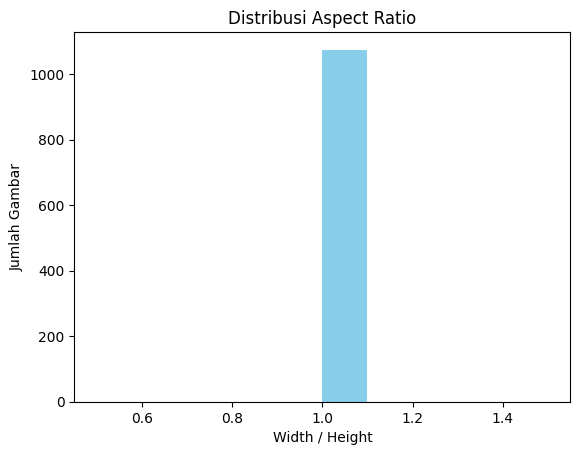

In [ ]:
category = os.listdir(data_dir)
aspect_ratios = []
resolutions = []

for file in os.listdir(data_dir):
    img_path = os.path.join(data_dir, file)
    if os.path.isfile(img_path) and file.lower().endswith(('.jpg', '.jpeg', '.png')):
        try:
            img = Image.open(img_path)
            w, h = img.size
            aspect_ratios.append(w / h)
            resolutions.append((w, h))
        except:
            continue

if aspect_ratios:
    plt.hist(aspect_ratios, bins=10, color='skyblue')
    plt.title("Distribusi Aspect Ratio")
    plt.xlabel("Width / Height")
    plt.ylabel("Jumlah Gambar")
    plt.show()
else:
    print("No valid images found.")


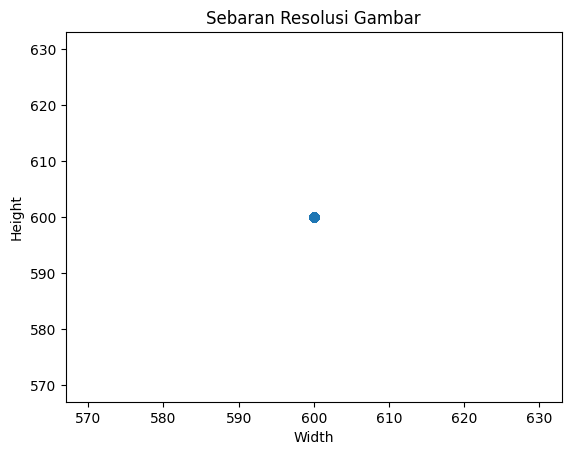

In [ ]:
w = [res[0] for res in resolutions]
h = [res[1] for res in resolutions]
plt.scatter(w, h, alpha=0.5)
plt.title("Sebaran Resolusi Gambar")
plt.xlabel("Width")
plt.ylabel("Height")
plt.show()

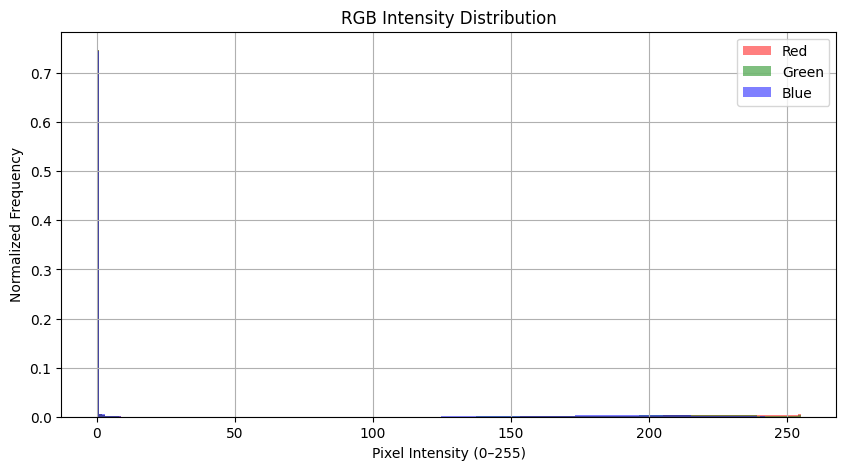

In [ ]:
image_files = [f for f in os.listdir(data_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

all_pixels = []

for file in image_files:
    img_path = os.path.join(data_dir, file)
    img = cv2.imread(img_path)
    if img is None:
        continue

    img = cv2.resize(img, (227, 227))
    all_pixels.append(img.reshape(-1, 3))

if not all_pixels:
    print("No valid images found.")
else:
    all_pixels = np.vstack(all_pixels)
    b_vals, g_vals, r_vals = all_pixels[:, 0], all_pixels[:, 1], all_pixels[:, 2]

    plt.figure(figsize=(10, 5))
    plt.hist(r_vals, bins=256, color='red', alpha=0.5, label='Red', density=True)
    plt.hist(g_vals, bins=256, color='green', alpha=0.5, label='Green', density=True)
    plt.hist(b_vals, bins=256, color='blue', alpha=0.5, label='Blue', density=True)

    plt.title("RGB Intensity Distribution")
    plt.xlabel("Pixel Intensity (0–255)")
    plt.ylabel("Normalized Frequency")
    plt.legend()
    plt.grid(True)
    plt.show()


# Splitting & Augmenting

In [ ]:
image_size = (100, 100)
batch_size = 32
AUTOTUNE = tf.data.AUTOTUNE

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/img_data",
    labels=None,
    label_mode=None,
    image_size=image_size,
    batch_size=batch_size,
    shuffle=True
)

Found 1074 files.


In [ ]:
total_batches = tf.data.experimental.cardinality(dataset).numpy()

train_idx = int(0.8 * total_batches)
val_idx = int(0.1 * total_batches)

train_ds = dataset.take(train_idx)
val_test_ds = dataset.skip(train_idx)

val_ds = val_test_ds.take(val_idx)
test_ds = val_test_ds.skip(val_idx)

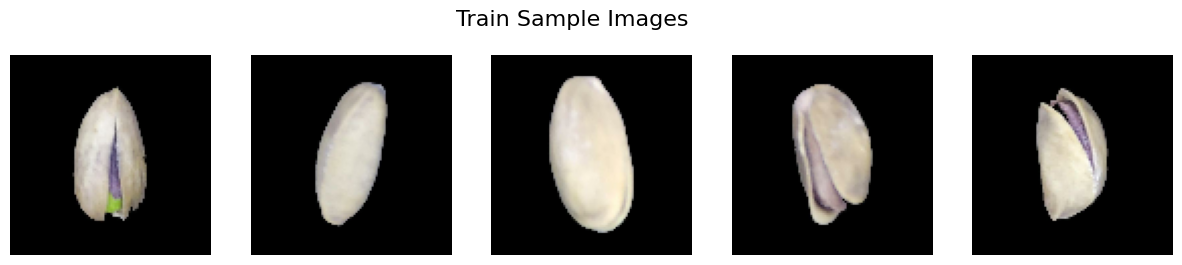

In [ ]:
def show_samples(dataset, title, n=5):
    plt.figure(figsize=(15, 3))
    for batch in dataset.take(1):
        for i in range(n):
            ax = plt.subplot(1, n, i + 1)
            img = batch[i].numpy()
            plt.imshow(img / 255.0)
            plt.axis("off")
    plt.suptitle(title, fontsize=16)
    plt.show()

show_samples(train_ds, "Train Sample Images")


In [ ]:
def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image

train_ds = train_ds.map(lambda x: normalize(x), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda x: normalize(x), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x: normalize(x), num_parallel_calls=AUTOTUNE)


In [ ]:
def add_noise(image):
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1)
    image = tf.clip_by_value(image + noise, 0.0, 1.0)
    return image


noise_train_ds = train_ds.map(lambda x: (add_noise(x), x), num_parallel_calls=AUTOTUNE)
noise_val_ds = val_ds.map(lambda x: (add_noise(x), x), num_parallel_calls=AUTOTUNE)
noise_test_ds = test_ds.map(lambda x: (add_noise(x), x), num_parallel_calls=AUTOTUNE)



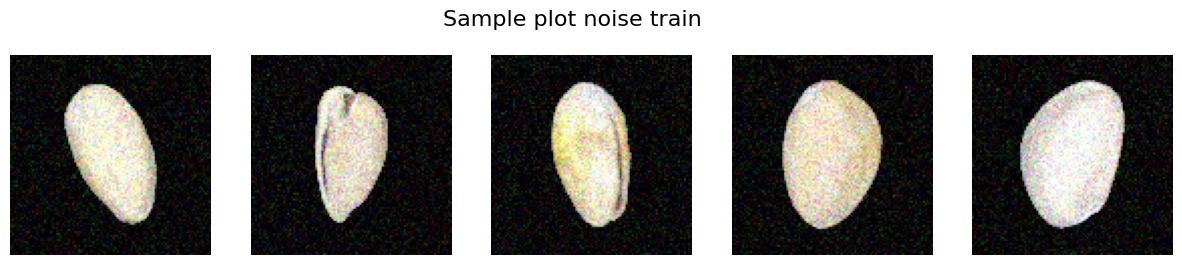

In [ ]:
plt.figure(figsize=(15, 3))
for noisy_imgs, clean_imgs in noise_train_ds.take(1):
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(noisy_imgs[i].numpy())
        plt.axis("off")
plt.suptitle("Sample plot noise train", fontsize=16)
plt.show()


# Base Model

In [ ]:
base_model = Sequential([
    Input(shape=(100, 100, 3)),
    Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', padding = 'same'),
    UpSampling2D((2, 2)),

    Conv2D(32, (3, 3), activation='relu', padding = 'same'),
    UpSampling2D((2, 2)),

    Conv2D(3, (3, 3), activation='sigmoid', padding = 'same')
])
base_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_29 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 25, 25, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_10 (UpSampling2D) │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 50, 50, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_11 (UpSampling2D) │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 100, 100, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,651 (295.51 KB)

 Trainable params: 75,651 (295.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
base_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics = ['mse']
)

In [ ]:
base_history = base_model.fit(
    noise_train_ds,
    epochs=30,
    batch_size=batch_size,
    validation_data=(noise_val_ds),
    verbose=1
)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.1439 - mse: 0.1439 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0086 - val_mse: 0.0086
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.0379 - mse: 0.0379 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0150 - mse: 0.0150 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.0051 - mse: 0.0051 - val_loss: 0.0038 - val_mse: 0.0038
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 114ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0037 - val_mse: 0.0037
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 91ms/step - loss: 0.0036 - mse: 0.0036 - val_loss: 0.0033 - val_mse: 0.0033
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0

In [ ]:
for base_input_images, base_target_images in noise_test_ds.take(1):
    base_awal = base_target_images.numpy()
    base_hasil = base_model.predict(base_input_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step


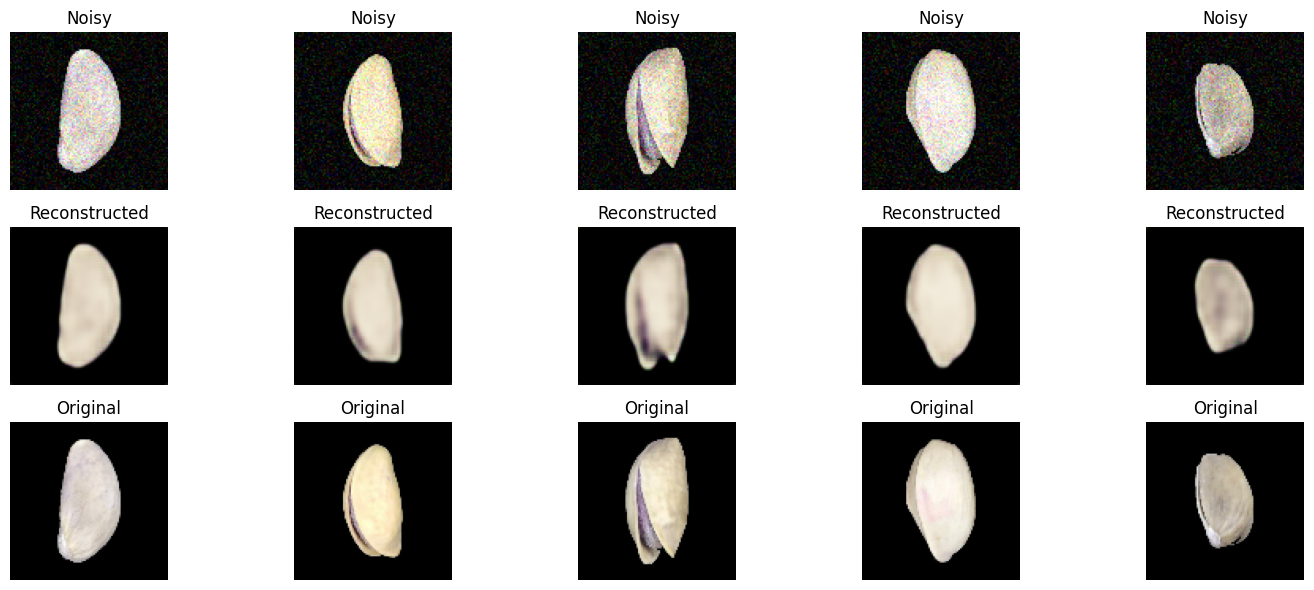

In [ ]:
n = 5
plt.figure(figsize=(15, 6))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(base_input_images[i].numpy())
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(base_hasil[i])
    plt.title("Reconstructed")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(base_awal[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()


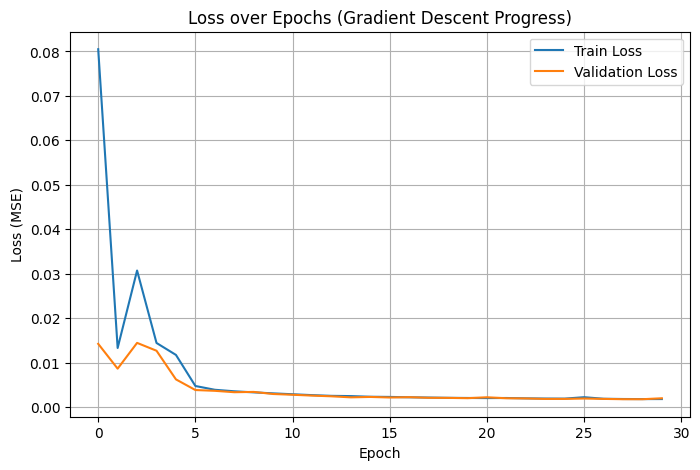

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(base_history.history['loss'], label='Train Loss')
plt.plot(base_history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs (Gradient Descent Progress)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
base_ssim = []
for i in range(len(base_hasil)):
    img1 = base_hasil[i]
    img2 = base_awal[i]

    per_channel = [ssim(img1[..., c], img2[..., c], data_range=1.0) for c in range(3)]
    base_ssim.append(sum(per_channel) / 3)

print("Rata-rata SSIM: ", sum(base_ssim) / len(base_ssim))

Rata-rata SSIM:  0.9261574058964136


# Modified Model

In [ ]:
modified_model = Sequential([
    Input(shape=(100, 100, 3)),

    Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(0.1),
    MaxPooling2D((2, 2), padding='same'),

    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(0.1),
    MaxPooling2D((2, 2), padding='same'),

    UpSampling2D((2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(0.1),

    UpSampling2D((2, 2)),
    Conv2D(32, (3, 3), padding='same'),
    LeakyReLU(0.1),

    Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])

In [ ]:
modified_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics = ['mse']
)

In [ ]:
os.makedirs('/content/models', exist_ok=True)

In [ ]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=8,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
    filepath='/content/models/best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    verbose=1
  )
]

In [ ]:
mod_history = modified_model.fit(
    noise_train_ds,
    epochs=30,
    batch_size=batch_size,
    validation_data=(noise_val_ds),
    callbacks = callbacks,
    verbose=1
)


Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1214 - mse: 0.1214
Epoch 1: val_loss improved from -inf to 0.00370, saving model to /content/models/best_model.keras
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1191 - mse: 0.1191 - val_loss: 0.0037 - val_mse: 0.0037 - learning_rate: 0.0010
Epoch 2/30
26/27 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0038 - mse: 0.0038
Epoch 2: val_loss did not improve from 0.00370
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0029 - val_mse: 0.0029 - learning_rate: 0.0010
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0032 - mse: 0.0032
Epoch 3: val_loss did not improve from 0.00370
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0032 - mse: 0.0032 - val_loss: 0.0028 - val_mse: 0.0028 - learning_rate: 0.0010
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0030 - mse: 0.0030
Epoch 4: val_loss did not improve from 0.00370
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.

In [ ]:
for mod_input_images, mod_target_images in noise_test_ds.take(1):
    modified_awal = mod_target_images.numpy()
    modified_hasil = modified_model.predict(mod_input_images)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step


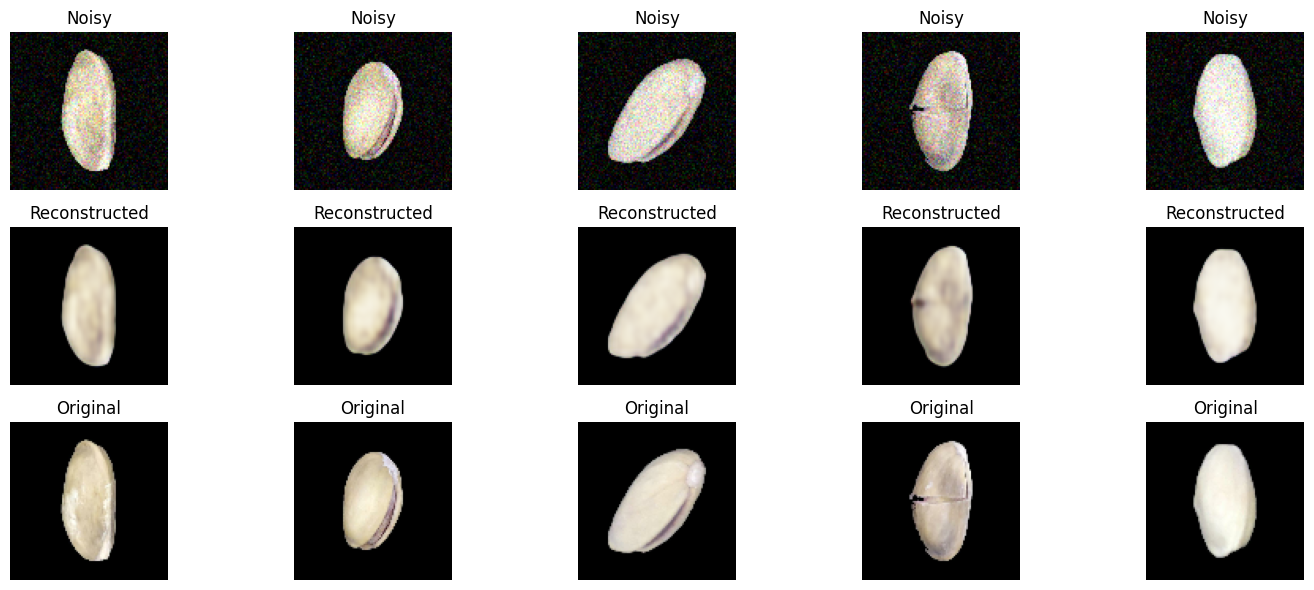

In [ ]:
n = 5
plt.figure(figsize=(15, 6))

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(mod_input_images[i].numpy())
    plt.title("Noisy")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(modified_hasil[i])
    plt.title("Reconstructed")
    plt.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(modified_awal[i])
    plt.title("Original")
    plt.axis("off")

plt.tight_layout()
plt.show()


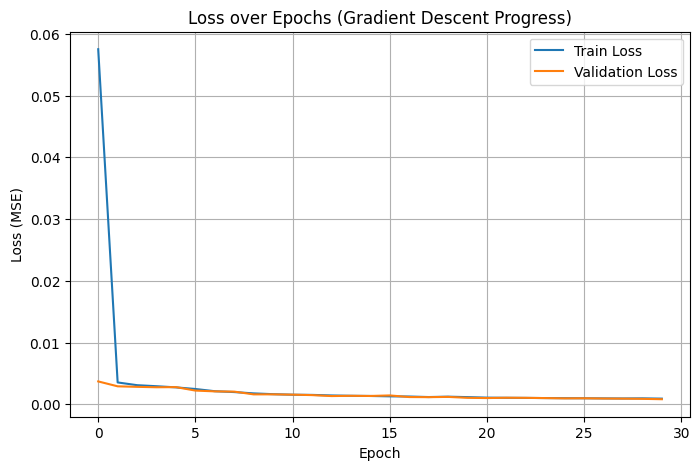

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(mod_history.history['loss'], label='Train Loss')
plt.plot(mod_history.history['val_loss'], label='Validation Loss')
plt.title("Loss over Epochs (Gradient Descent Progress)")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
mod_ssim = []
for i in range(len(modified_hasil)):
    img1 = modified_hasil[i]
    img2 = modified_awal[i]

    per_channel = [ssim(img1[..., c], img2[..., c], data_range=1.0) for c in range(3)]
    mod_ssim.append(sum(per_channel) / 3)

print("Rata-rata SSIM: ", sum(mod_ssim) / len(mod_ssim))

Rata-rata SSIM:  0.9497672731715303


# Result

Dari Hasil diatas dapat dilihat dari kedua model modified AUtoencoder memiliki hasil SSIM yang lebih tinggi dibanding dengan base model, hal ini kemungkinan terjadi karena penggunaan activation LeakyReLu yang memungkinkan neuron yang seharusnya mati untuk recover agar informasinya tidak hilang didalam, sehingga menghilangkan kemungkinan terjadinya image yang memiliki patch kosong (putih), disini juga penggunaan callback reduce LRonPlateau menstabilisasikan graph training pada model, dimana pada saat base model melakukan training terjadi spiking sedikit sebelum mentsabilisasi dibanding modified AutoEncoder yang langsung menstabilkan dirinya. Sehingga dapat disimpulkan modified Model mendapatkan hasil yang lebih bagus